# Genetic Algorithms & Nim's Game


Rules of Nim's game:

* There are 20 sticks, 2 players.
* The players remove sticks in turns.
* To win, a player has to remove the last stick.
* Players may only remove 1, 2 or 3 stick(s) each turn.

Now, let's think of what is a "strategy" for this game.

Basically, if given a number of sticks remaining, a trategy tells us how many we should remove;
i.e. for any number $n \in \mathbb{N}$, a strategy outputs a number of sticks to remove $r\in \{ 1,2,3 \}$.

So a strategy $s$ is basically a function $s: \mathbb{N} \to \{ 1,2,3 \}$.

Our goal is now to find the optimal strategy $s^*$ (say).
This is the strategy that would (should) win against any other strategy at least 50% of the time (wins 50% of the time against itself, depending on which one starts).

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Let's implement some basic trategies:

1. *random*: removes 1, 2 or 3 sticks at random
2. *max*: always removes 3 sticks
3. *min*: always removes 1 stick
4. *min-max*: removes wins if possible (i.e. if there is 1,2, or 3 sticks left), otherwise, removes a single stick.



In [2]:
def strat_random(n):
  return min(n, random.choice([1,2,3]))

In [3]:
def strat_max(n):
  return min(n, 3)

In [4]:
def strat_min(n):
  return min(n, 1)

In [5]:
def strat_min_max(n):
  if n<=3:
    return n
  else:
    return 1

**[conjecture what which one will win against which other...]**

Let's make a tournament to check you conjecture.

We start by defining a `game` function, that takes two strategies a number of sticks, and returns `0` or `1` depending on which player (strategy) wins.

In [6]:
def game(strat1, strat2, n=20):
  while n>=0:
    n -= strat1(n)
    if n<=0:
      return 1
    n -= strat2(n)
    if n<=0:
      return 0

In [7]:
game(strat_min, strat_max)

0

Then, we define a `games` function, that repeats the game function a given number of times, and summs the results.

In [8]:
def games(strat1, strat2, n=20, nb_matches=10**4):
  wins = 0
  for i in range(nb_matches):
    wins += game(strat1, strat2, n)
  return wins

In [9]:
NB_MATCHES=10**5

In [10]:
games(strat_random, strat_min, nb_matches=NB_MATCHES)/NB_MATCHES

0.66697

In [11]:
games(strat_max, strat_max, nb_matches=NB_MATCHES)/NB_MATCHES

1.0

We finally define a tournament, that makes games between every strategies:

In [12]:
def tournament(strats_list, n=20, nb_matches=10**4):
  scores = np.zeros( (len(strats_list), len(strats_list)), dtype=np.int32)
  for i, strat1 in enumerate(strats_list):
    for j, strat2 in enumerate(strats_list):
      scores[i,j] = games(strat1, strat2, n, nb_matches)
  return scores

We plot the tournament reults:

In [13]:
# options
NB_MATCHES = 10**4
N = 20
STRATS_NAMES = ["random", "min", "max", "min-max"]
STRATS = [strat_random, strat_min, strat_max, strat_min_max]
# make tournament
scores = tournament(STRATS, n=N, nb_matches=NB_MATCHES)
# print results
pd.DataFrame(scores/NB_MATCHES, STRATS_NAMES, STRATS_NAMES)

,random,min,max,min-max
random,0.5041,0.67,0.3606,0.1122
min,0.3351,0.00,0.0000,0.0000
max,0.5200,0.00,1.0000,0.0000
min-max,0.8940,1.00,0.0000,0.0000


**[is this what you expected?]**

Now, let's see is we can try to "visualize" a strategy...
We will plot the *function* that represents the strategy.

*(in the case of the random strategy, we can take an average)*

In [14]:
def average_take(strat, n_max=20, nb_draws=10**4):
  y = np.zeros(n_max)
  for n in range(n_max):
    s = 0
    for i in range(nb_draws):
      s += strat(n+1)
    y[n] = s/nb_draws
  return y

In [15]:
N = 20
NB_DRAWS = 10**4
print(average_take(strat_random, n_max=N, nb_draws=NB_DRAWS))

[1.     1.6616 1.9984 2.0033 1.9965 2.0066 1.9893 2.001  1.9985 2.0041
 2.0036 1.9964 1.9934 1.9974 1.9878 2.0135 2.0154 1.9977 2.0063 2.0124]


In [16]:
def plot_average_take(strat, n_max=20, nb_draws=10**4, **args):
  x = np.arange(n_max, dtype=np.int32)+1
  y = average_take(strat, n_max, nb_draws)
  plt.plot(x,y,'-*', **args)
  plt.xticks(list(range(1,n_max+1)))
  plt.xlabel('# stricks remaining')
  plt.yticks(list(range(0,5)))
  plt.ylabel('# stricks taken')

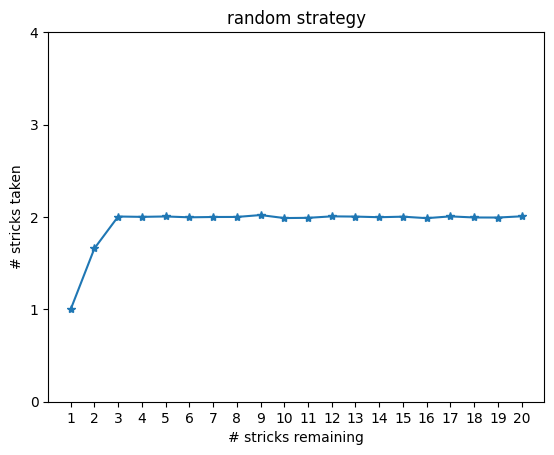

In [17]:
N = 20
NB_DRAWS = 10**4
plt.title('random strategy')
plot_average_take(strat_random, n_max=N, nb_draws=NB_DRAWS)
plt.show()

In [18]:
def plot_average_take_multi(strats, strats_names, n_max=20, nb_draws=10**4):
  x = np.arange(n_max, dtype=np.int32)+1
  i = -len(strats)//2
  for strat, strat_names in zip(strats,strats_names):
    y = average_take(strat, n_max, nb_draws)+(i*0.05)
    plt.plot(x,y,'-*', label=strat_names)
    i+=1
  plt.xticks(list(range(1,n_max+1)))
  plt.xlabel('# stricks remaining')
  plt.yticks(list(range(0,5)))
  plt.ylabel('# stricks taken')
  plt.legend()

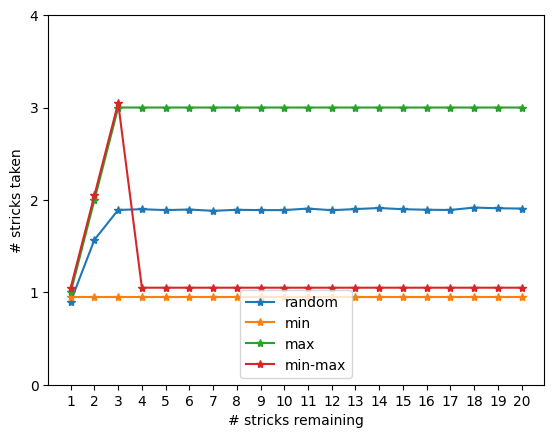

In [19]:
N = 20
NB_DRAWS = 10**4
plot_average_take_multi(STRATS, STRATS_NAMES, n_max=N, nb_draws=NB_DRAWS)

-----

These were very basic strategies... now let's try to find ***THE*** best strategy.

To do so, we need to optimize the strategy $s: \mathbb{N} \to \{1,2,3\}$.
We will tackle this optimization task using a **"genetic algorithm"**.

-----

**Principle:**

We have a population of individuals, each with their own strategy.
This strategy is encoded in their DNA.
The DNA will therefore be a list of length 20, with values in $\{1,2,3\}.

The strategy of the population is, for each turn, to choose an individual at random to play a turn.

**Optimization:**

We have a population made of individuals with DNA... Let's use the process of natural selection to imporve the population's fitness (i.e. improve the population's strategy).

A population will give birth to a new a new generation through 3 stages:
1. *selection*: evaluate the performances of each individual, and kill the forst ones
2. *reproduction*: use the surviving individuals to create a new population: choose two *parents* at random, and make them have a *child*; strat over untill a full population is created
3. *mutation*: randomly make some changes in the DNA (to allow the emergence of new strategies)

We start with a population drawn at random, and hope to improve it over generations.

In [20]:
N = 20
POP_SIZE = 400
POP_SELECTION_SIZE = 50
NB_GAMES_EVAL = 10**2
MUTATION_PROBA = 5e-3
NB_GENERATIONS = 11

Generate a random population (use numpy), for a game with `N` sticks and a population of size `POP_SIZE`.

In [21]:
def random_pop():
  global POP_SIZE, N
  rand = np.random.random(N*POP_SIZE)*3
  shaped_rand = rand.reshape((POP_SIZE, N))
  int_rand = np.floor(shaped_rand).astype(dtype=np.int32)
  return int_rand+1

In [22]:
pop = random_pop()
pop[:3,:]

array([[1, 2, 3, 3, 2, 2, 1, 2, 1, 3, 1, 3, 1, 3, 2, 1, 2, 2, 1, 2],
       [2, 2, 3, 3, 1, 1, 3, 3, 3, 1, 2, 3, 1, 3, 1, 3, 3, 1, 1, 3],
       [3, 1, 1, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 3, 3, 2, 1, 1]])

Define a strategy that follows this random population: pick one individual at random and let it play.

In [23]:
def strat_pop(n):
  global pop, POP_SIZE
  i = int(random.random()*POP_SIZE)
  return min(n, pop[i,n-1])
strat_pop(5)

3

Plot this random population using `plot_average_take` and `NB_DRAWS`; it should oscillate around 2.

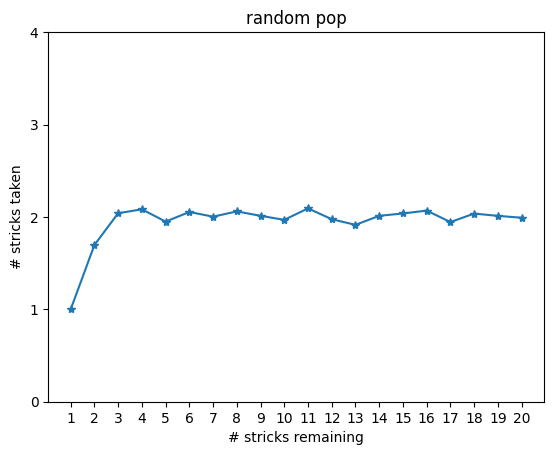

In [24]:
plt.title('random pop')
plot_average_take(strat_pop, n_max=N, nb_draws=NB_DRAWS)

Define a function that evaluates the fitness of a population against an other strategy: for each individual, the fitness is the number of wins of this individual against the opposing strategy out of `NB_GAMES_EVAL`.

In [25]:
def eval_pop(strat_opp):
  global pop, N, POP_SIZE, NB_GAMES_EVAL
  fitness = np.zeros(POP_SIZE)
  for i in range(POP_SIZE):
    strat_gene = lambda n: min(pop[i, n-1], N)
    f = games(strat_opp, strat_gene, n=N, nb_matches=NB_GAMES_EVAL//2)
    f -= games(strat_gene, strat_opp, n=N, nb_matches=NB_GAMES_EVAL//2)
    fitness[i] = f
  return fitness

In [26]:
fitness = eval_pop(strat_random)
fitness[:10]

array([-17., -28.,  10., -15., -15.,  24.,  -6.,  11.,   7., -24.])

Define a seletion on the population: take the `POP_SELECTION_SIZE` most fit indiviuals of the population.

In [27]:
def select_pop():
  global pop, fitness, POP_SELECTION_SIZE
  fitness_index = fitness.argsort()
  selected_pop = pop[fitness_index[:POP_SELECTION_SIZE], :]
  return selected_pop

In [28]:
selected_pop = select_pop()
selected_pop[:3,:]

array([[2, 3, 3, 1, 1, 2, 3, 2, 1, 3, 2, 2, 3, 1, 1, 1, 2, 3, 1, 3],
       [3, 2, 3, 1, 1, 3, 3, 2, 1, 1, 3, 2, 1, 3, 2, 1, 3, 1, 3, 3],
       [1, 3, 3, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 1, 3, 2, 3, 2, 2]])

Define a child function, that takes two individuals, and create a trustworthy child by mixing the genes randomly.

In [29]:
def child(gene1, gene2):
  global N
  child = np.zeros(N, dtype=np.int32)
  choice = np.floor(np.random.random(N)*2)
  for i in range(N):
    if choice[i]==1:
      child[i] = gene1[i]
    else:
      child[i] = gene2[i]
  return child

Define a reproduction function for the population, that fills a new population with childs of parents taken in the selected population.

In [30]:
def reproduce_pop():
  global selected_pop, POP_SIZE, N, POP_SELECTION_SIZE
  new_pop = np.zeros((POP_SIZE, N), dtype=np.int32)
  for i in range(POP_SIZE):
    a = int(random.random()*POP_SELECTION_SIZE)
    b = int(random.random()*POP_SELECTION_SIZE)
    new_pop[i,:] = child(selected_pop[a,:], selected_pop[b,:])
  return new_pop

Plot the original population and the next generation (after reproducing once)

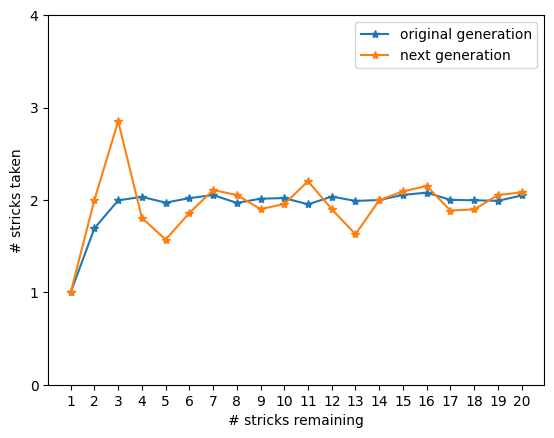

In [31]:
pop = random_pop()
plot_average_take(strat_pop, n_max=N, nb_draws=NB_DRAWS, label="original generation")
pop = reproduce_pop()
plot_average_take(strat_pop, n_max=N, nb_draws=NB_DRAWS, label="next generation")
plt.legend()
plt.show()

Define a mutation function, that add random mutations to a population, according to `MUTATION_PROBA`.

In [32]:
def mutate_pop():
  global pop, N, POP_SIZE, MUTATION_PROBA
  mut = np.random.random(N*POP_SIZE)<MUTATION_PROBA
  s = np.sum(mut)
  shaped_mut = mut.reshape((POP_SIZE, N))
  mutated = np.floor(np.random.random(s)*3).astype(np.int32)+1
  pop[shaped_mut] = mutated
  return pop

In [33]:
pop = mutate_pop()

Finally, define an evolving function, that creates a random population, and makes it evolve for `NB_GENERATIONS` against a given opposing strategy.

In [34]:
def evolve(strat_opp, disp=True):
  global pop, fitness, selected_pop, NB_GENERATIONS, NB_DRAWS, N
  pop = random_pop()
  for generation in range(NB_GENERATIONS):
    if disp:
      plt.title(f'generation {generation:02d}')
      plot_average_take(strat_pop, n_max=N, nb_draws=NB_DRAWS)
      plt.show()
    fitness = eval_pop(strat_opp)
    selected_pop = select_pop()
    pop = reproduce_pop()
    pop = mutate_pop()

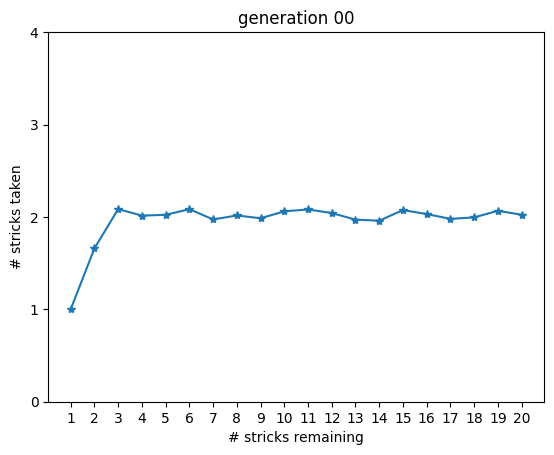

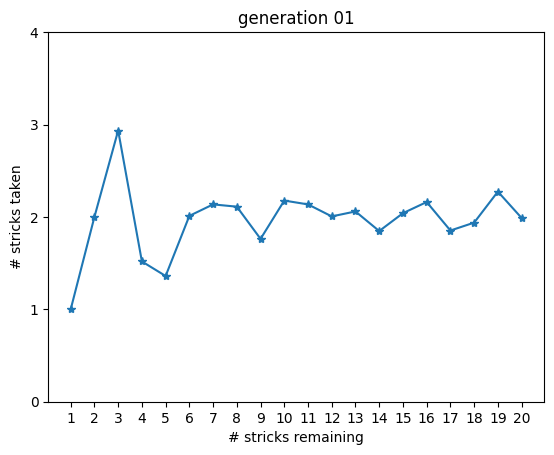

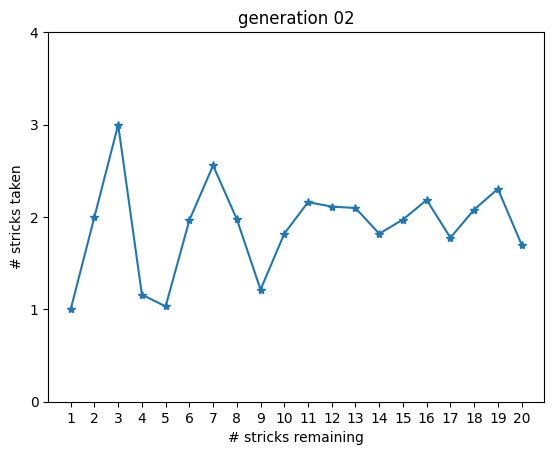

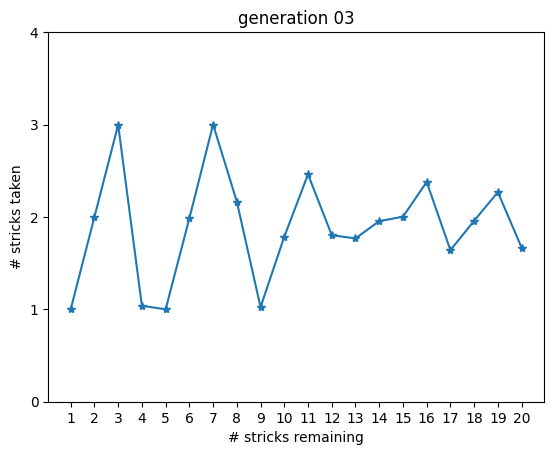

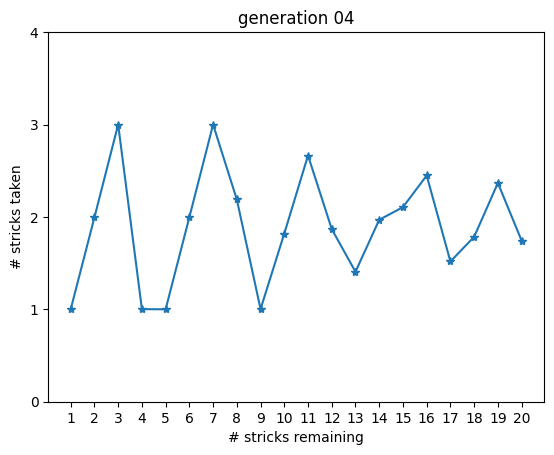

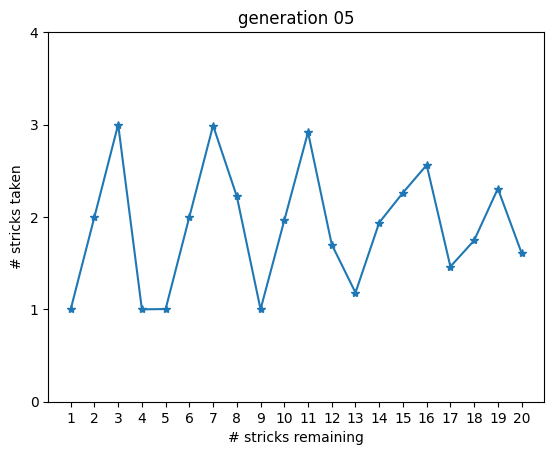

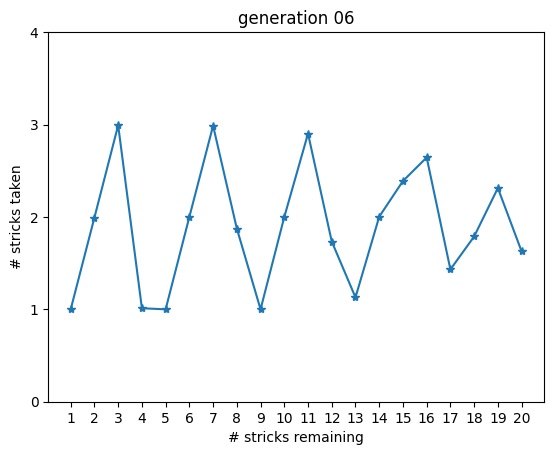

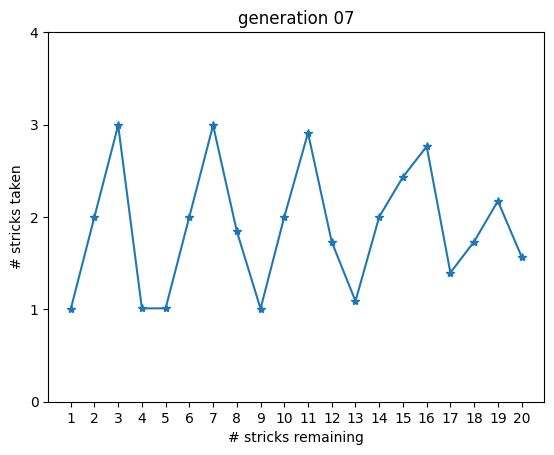

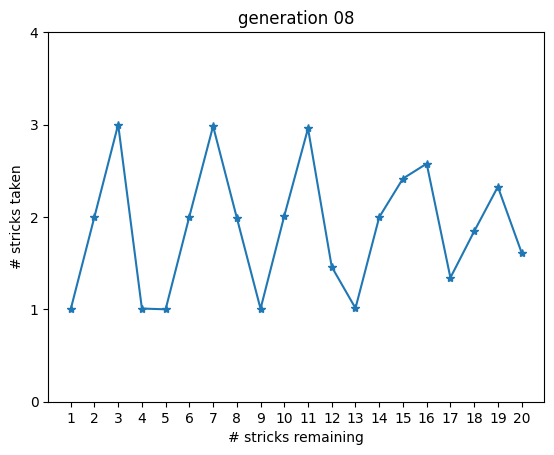

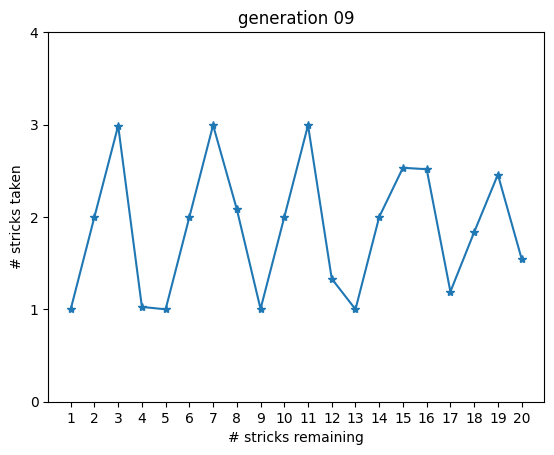

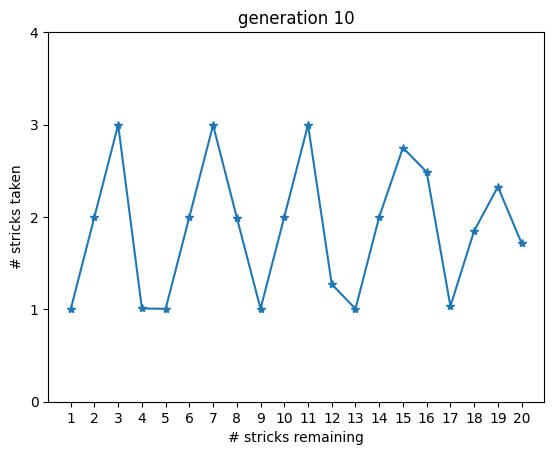

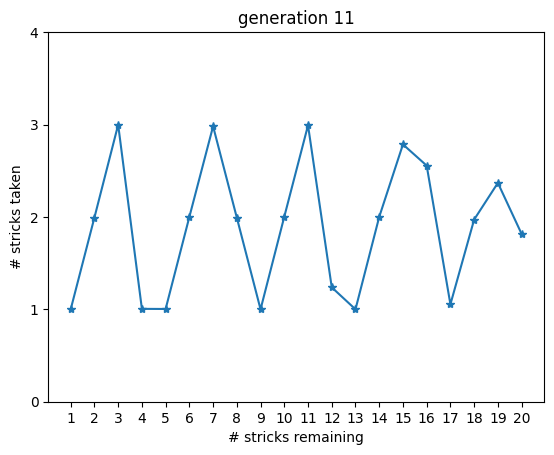

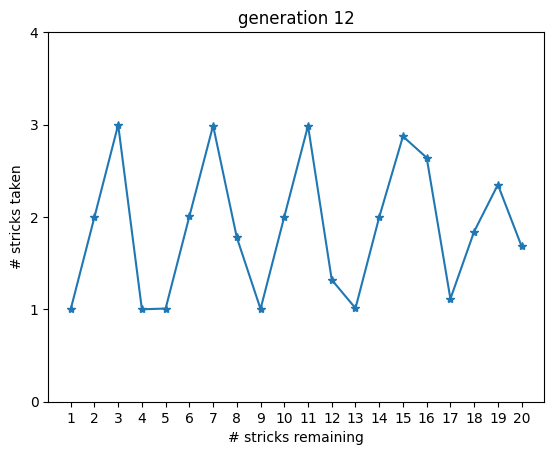

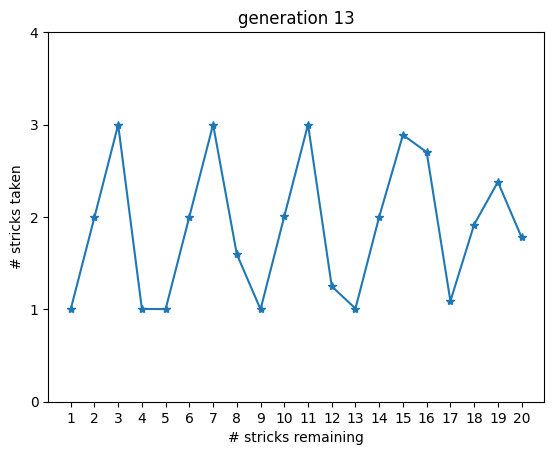

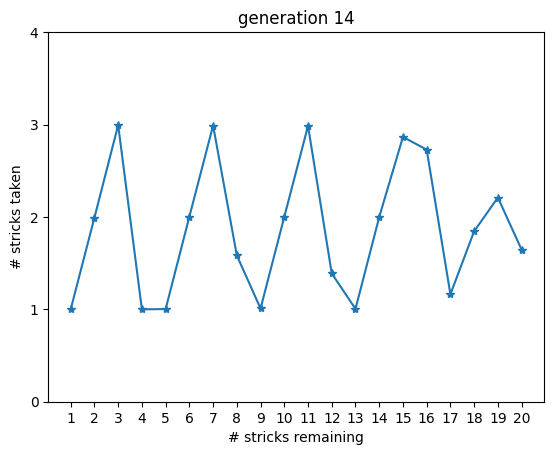

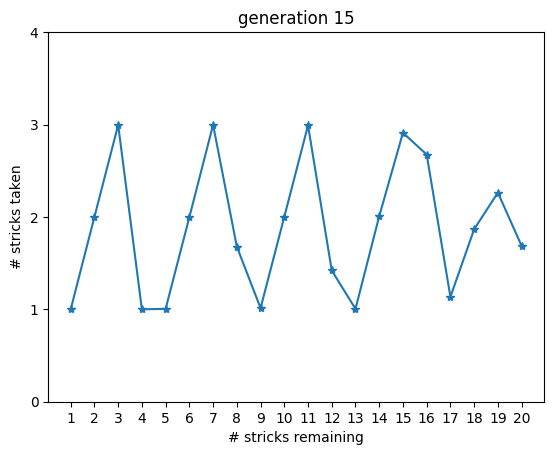

In [35]:
# train against random strategy
NB_GENERATIONS=16
evolve(strat_random)

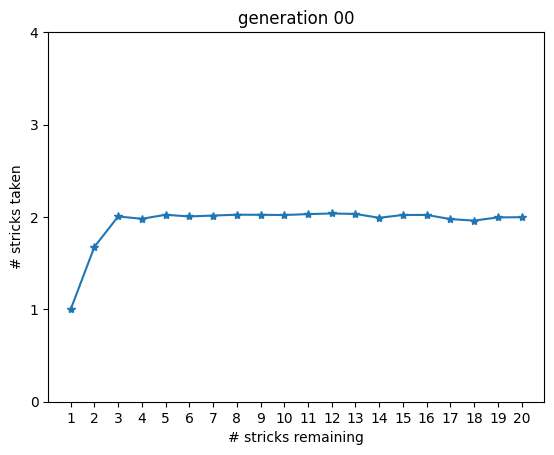

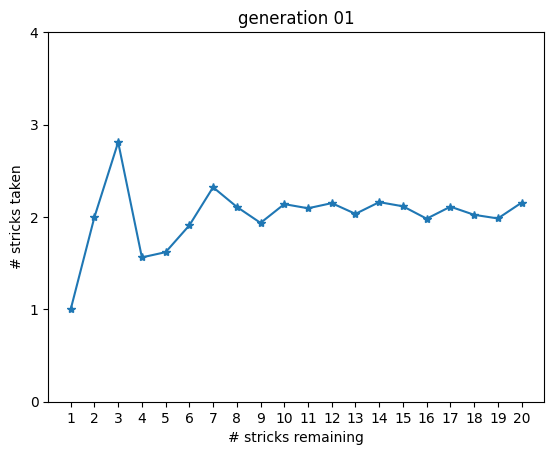

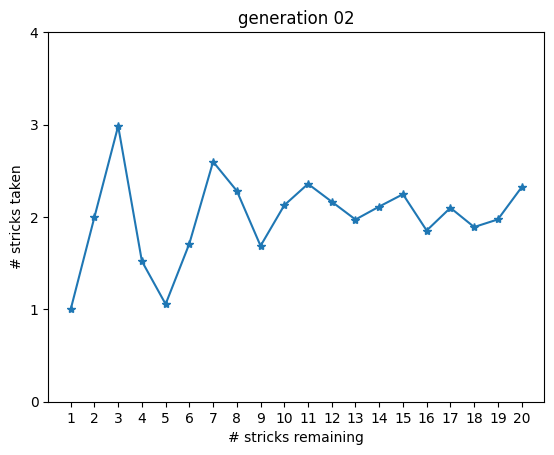

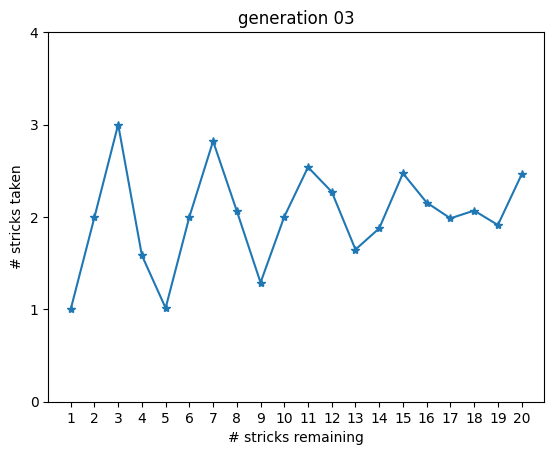

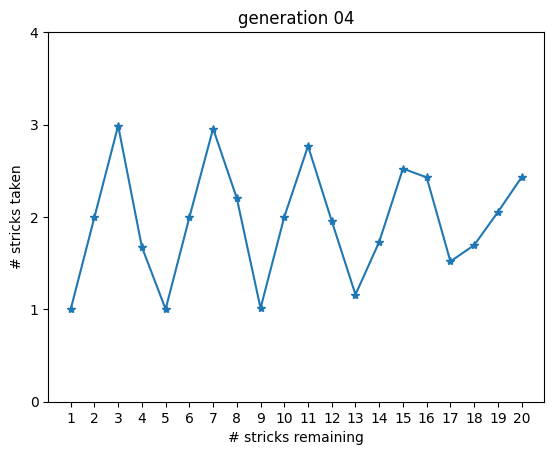

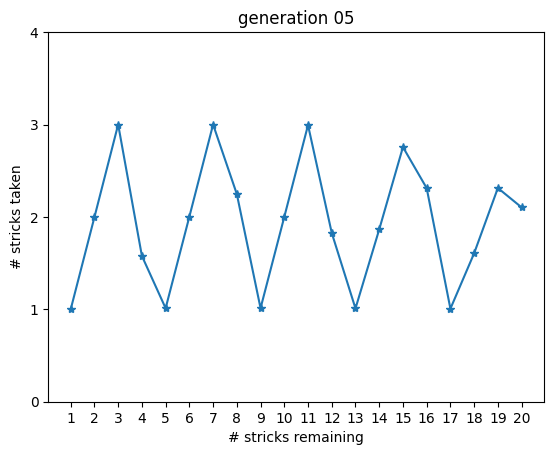

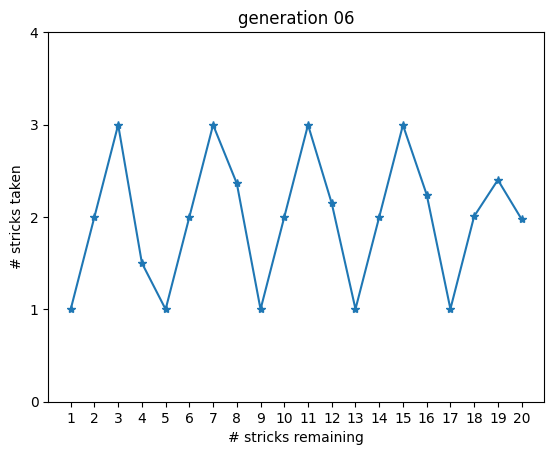

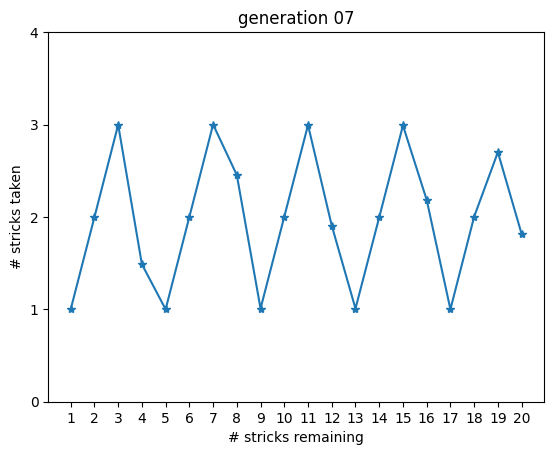

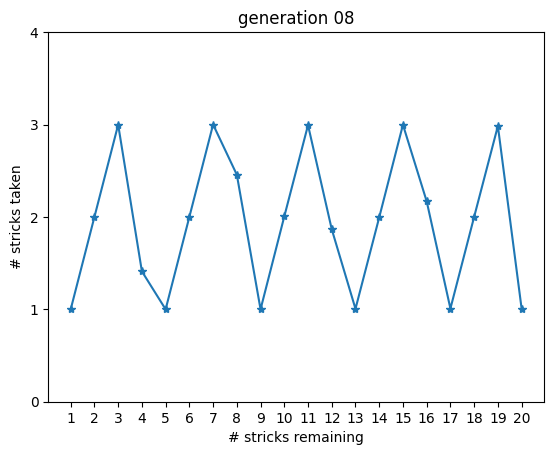

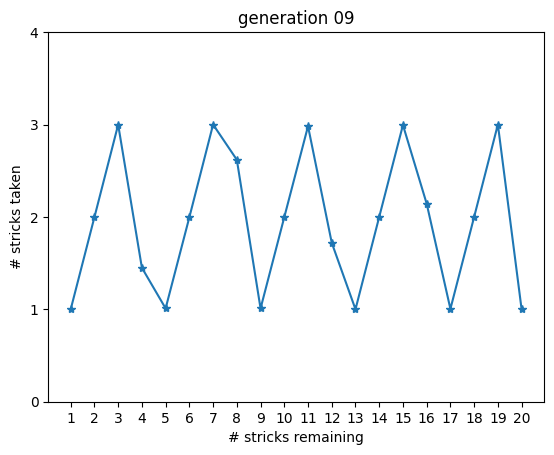

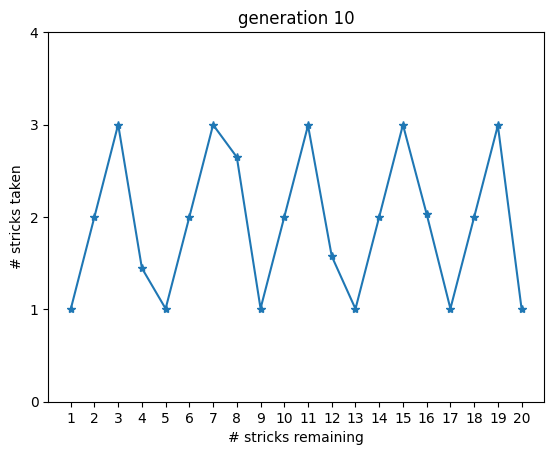

In [36]:
# train against itself
NB_GENERATIONS=11
evolve(strat_pop)

Training against itself works better, so we'll use that technique for final training

In [37]:
NB_GENERATIONS=21
evolve(strat_pop, disp=False)

We plot the final genetic strategy

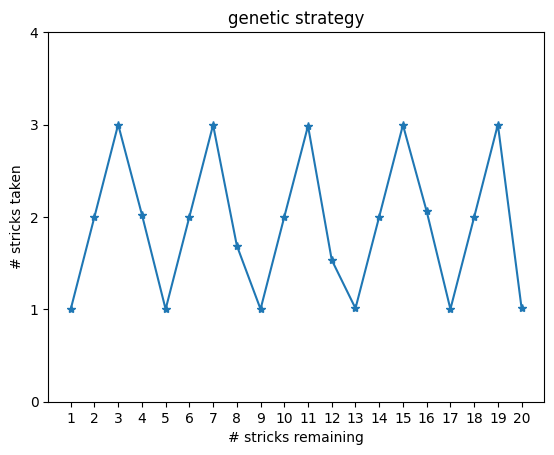

In [38]:
plt.title('genetic strategy')
plot_average_take(strat_pop, n_max=N, nb_draws=NB_DRAWS)
plt.show()

**[can you deduce what is *THE* optimal strategy?]**

Let's write out the mathematical optimal strategyn, and test it against others.

In [39]:
def strat_optim(n):
  if n%4==0:
    return 2 # anything here, there is no "good" answer
  else:
    return n%4

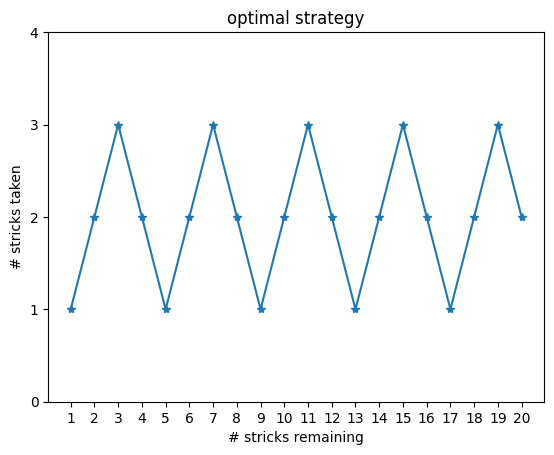

In [40]:
plt.title('optimal strategy')
plot_average_take(strat_optim, n_max=N, nb_draws=NB_DRAWS)
plt.show()

Now we make a final tournament to see which strategy is the best

In [41]:
# options
NB_MATCHES = 10**4
STRATS_NAMES = ["random", "min", "max", "min-max", "genetic", "optimal"]
STRATS = [strat_random, strat_min, strat_max, strat_min_max, strat_pop, strat_optim]
# make tournament
scores = tournament(STRATS, n=N, nb_matches=NB_MATCHES)
# print results
pd.DataFrame(scores/NB_MATCHES, STRATS_NAMES, STRATS_NAMES)

,random,min,max,min-max,genetic,optimal
random,0.5017,0.6646,0.3563,0.1088,0.0013,0.0
min,0.3297,0.0000,0.0000,0.0000,0.0000,0.0
max,0.5282,0.0000,1.0000,0.0000,0.0075,0.0
min-max,0.8919,1.0000,0.0000,0.0000,0.0004,0.0
genetic,0.9917,1.0000,0.9959,0.9993,0.0095,0.0
optimal,0.9924,1.0000,1.0000,1.0000,0.0092,0.0


To finish, we compare the plots of the differents strategies

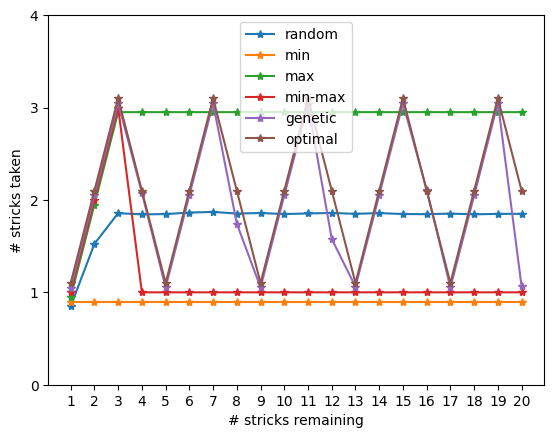

In [42]:
NB_DRAWS = 10**4
plot_average_take_multi(STRATS, STRATS_NAMES, n_max=N, nb_draws=NB_DRAWS)